# Examination of the arms of spiral galaxies in the *Galaxy Builder* sample

This notebook loads in the *Galaxy Builder* aggregation results, and overlays the resulting logarithmic (non-bayesian) spiral arm fits on SDSS r-band images of the galaxies.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import AsinhStretch
from gzbuilder_analysis import load_aggregation_results
from gzbuilder_analysis.aggregation.spirals.oo import Arm
from gzbuilder_analysis.data import download_sdss_rgb_cutout

In [3]:
agg_res = load_aggregation_results('lib/aggregation_results')

In [4]:
fm = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
arms = agg_res.apply(lambda a: a.spiral_arms).apply(pd.Series).add_prefix('arm-')

In [6]:
two_or_more_arms = arms[arms.notnull().sum(axis=1) > 1]

In [7]:
selection = two_or_more_arms[
    two_or_more_arms
    .applymap(lambda a: a.pa if isinstance(a, Arm) else np.nan)
    .apply(
        lambda a: a.max() - a.min() > 20,
        axis=1
    )
]

In [8]:
s = AsinhStretch()

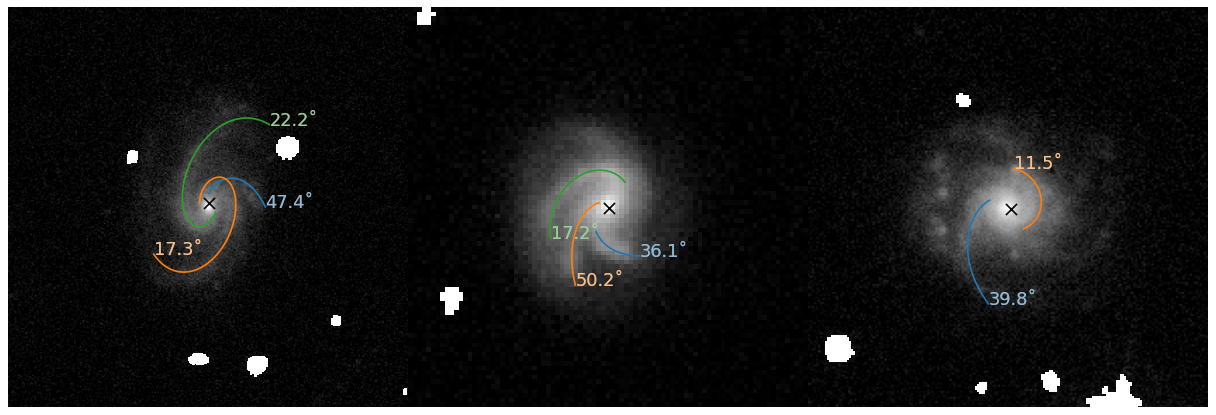

In [9]:
f, axs = plt.subplots(ncols=3, dpi=80, figsize=(5 * 3, 5))
idxs = [2, 5, 6]
for ax, i in zip(axs, idxs):
    plt.sca(ax)
    plt.imshow(s(fm.loc[selection.index[i]]['galaxy_data']), cmap='gray')
    for j, arm in enumerate(selection.iloc[i].dropna()):
        p = 0 if (
            np.add.reduce((arm.reprojected_log_spiral[0] - arm.centre_pos)**2)
            > np.add.reduce((arm.reprojected_log_spiral[-1] - arm.centre_pos)**2)
        ) else -1
        plt.plot(*arm.reprojected_log_spiral.T, c=f'C{j}')
        plt.text(*arm.reprojected_log_spiral[p], f'{arm.pa:.1f}˚', c=f'w', fontsize=16)
        plt.text(*arm.reprojected_log_spiral[p], f'{arm.pa:.1f}˚', c=f'C{j}', alpha=0.5, fontsize=16)
    plt.scatter(*arm.centre_pos, c='k', marker='x', s=100)
    plt.axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig('plots/example-spiral-angles.pdf', bbox_inches='tight')

We'll also plot some examples of barred galaxies:

In [10]:
catalog = pd.read_csv('lib/galaxy-builder-catalogue.csv').set_index('galaxy_builder_id')

In [11]:
image_locs = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0) \
    .metadata \
    .apply(json.loads).apply(pd.Series) \
    [['ra', 'dec']] \
    .drop_duplicates() \
    .reindex(np.unique(catalog.query('bar_fraction > 0.05').index)) \
    .dropna()
print(len(image_locs))

28


In [12]:
image_locs = catalog.query('bar_fraction > 0.05').sort_values('chisq')[['ra', 'dec']].head(16)

In [13]:
ims = pd.Series([], dtype=object)
with tqdm(image_locs.iterrows(), total=len(image_locs)) as bar:
    for i, (idx, row) in enumerate(bar):
        data = fm['galaxy_data'].loc[idx]
        ims.loc[idx] = download_sdss_rgb_cutout(*row[['ra', 'dec']], fm['galaxy_data'].loc[idx].shape)

100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


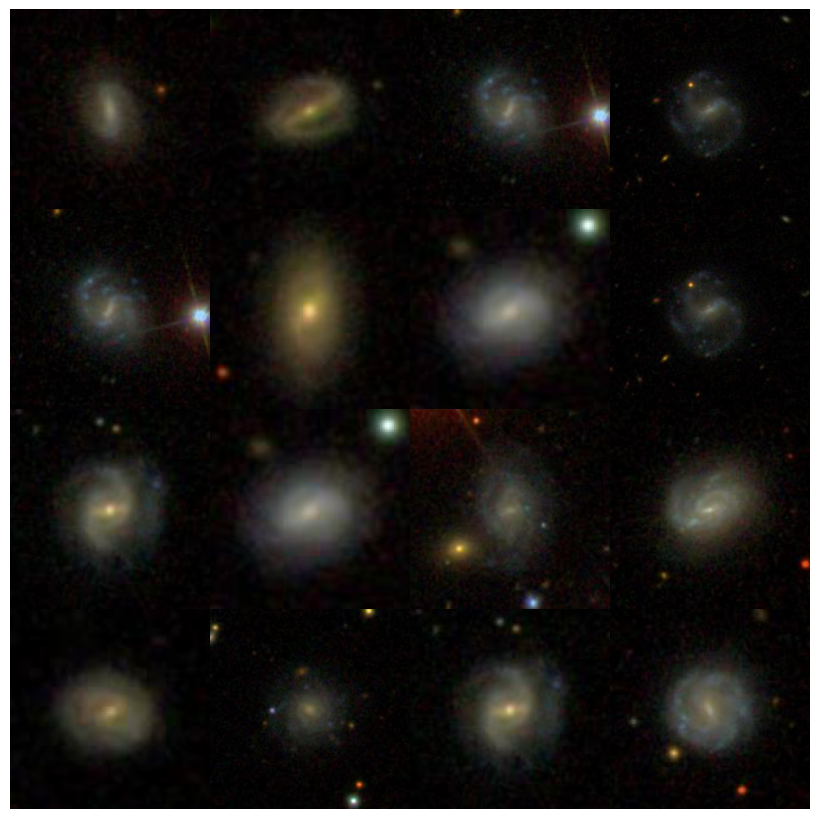

In [14]:
f, ax_ = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), dpi=100)
ax = ax_.ravel()
for i, (idx, row) in enumerate(image_locs.iterrows()):
    ax[i].imshow(ims.loc[idx])#.resize((200, 200), Image.HAMMING))
    ax[i].axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)

# Comparison of arm pitch angle results between the main and validation sets

Were the results for arm pitch angle consistent between the runs?

In [20]:
validation_ids = pd.read_csv('lib/duplicate_galaxies.csv').rename(columns={'0': 'main', '1': 'validation'})

Let's plot an example galaxy so we can see the difference between the recovered arms:

In [114]:
587731870169170029 - np.float64(example_galaxy['SDSS dr7 id'])

0.0

In [115]:
example_dr7_id = 587731870169170029

In [117]:
example_galaxy = validation_ids.query('`SDSS dr7 id` == @example_dr7_id')

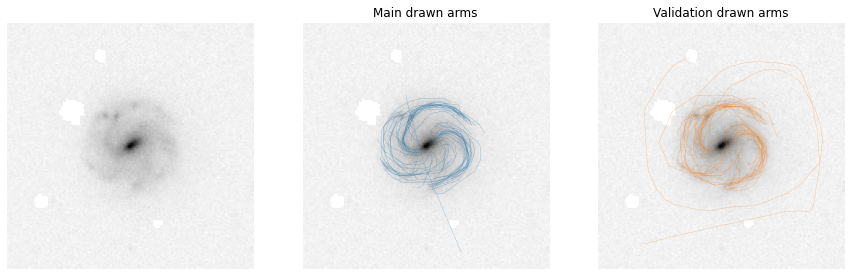

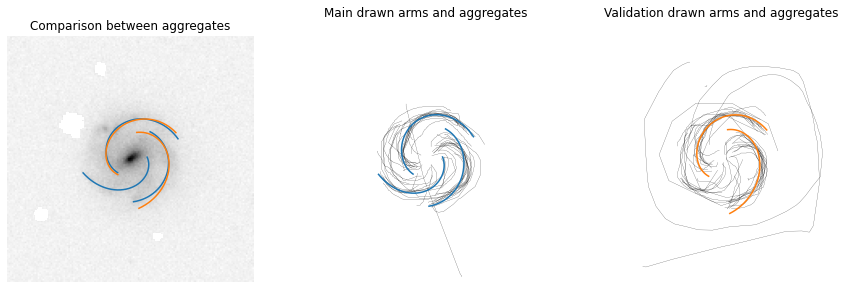

In [129]:
f, ax = plt.subplots(figsize=(15, 5), ncols=3, sharex=True, sharey=True)
[a.imshow(fm.loc[int(example_galaxy.main)].galaxy_data, cmap='gray_r', origin='lower') for a in ax]
plt.sca(ax[1])
for arm in agg_res.loc[int(example_galaxy.main)].spiral_pipeline.drawn_arms:
    plt.plot(*arm.T, c='C0', lw=0.2, alpha=0.9)
plt.title('Main drawn arms')
plt.sca(ax[2])
for arm in agg_res.loc[int(example_galaxy.validation)].spiral_pipeline.drawn_arms:
    plt.plot(*arm.T, c='C1', lw=0.2, alpha=0.9)
plt.title('Validation drawn arms')
[a.axis('off') for a in ax];

row = validation_ids.query('main == 20902011').squeeze()
main_arms = arms.loc[int(row.main)]
validation_arms = arms.loc[int(row.validation)]

assert len(row)
f, ax = plt.subplots(figsize=(15, 5), ncols=3, sharex=True, sharey=True)

plt.sca(ax[0])
for arm in main_arms.dropna().values:
    plt.plot(*arm.reprojected_log_spiral.T, c='C0')
for arm in validation_arms.dropna().values:
    plt.plot(*arm.reprojected_log_spiral.T, c='C1')
plt.imshow(fm.loc[int(example_galaxy.main)].galaxy_data, cmap='gray_r', origin='lower')
plt.title('Comparison between aggregates')

plt.sca(ax[1])
for arm in agg_res.loc[int(row.main)].spiral_pipeline.drawn_arms:
    plt.plot(*arm.T, c='k', lw=0.2, alpha=0.9)
for arm in main_arms.dropna().values:
    plt.plot(*arm.reprojected_log_spiral.T, c='C0')
plt.title('Main drawn arms and aggregates')
plt.sca(ax[2])
for arm in agg_res.loc[int(row.validation)].spiral_pipeline.drawn_arms:
    plt.plot(*arm.T, c='k', lw=0.2, alpha=0.9)
for arm in validation_arms.dropna().values:
    plt.plot(*arm.reprojected_log_spiral.T, c='C1')
plt.title('Validation drawn arms and aggregates')
[a.axis('off') for a in ax];

We can see fairly tight agreement in position, but the validation group failed to identify one of the arms.

A systematic evaluation of the differences here is difficult - one thing we can do is plot the component arms and eyeball the offsets

Text(0, 0.5, 'Arm pitch angle')

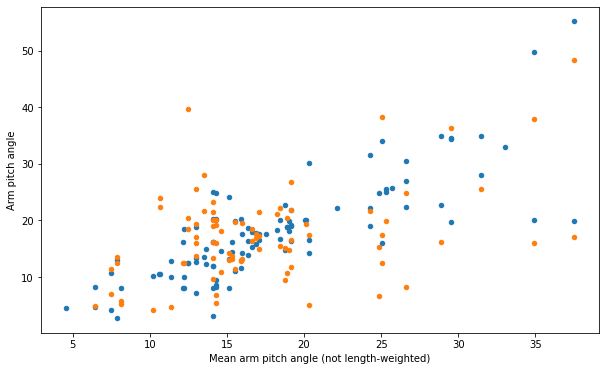

In [143]:
main_ = {}
validation_ = {}
for _, row in validation_ids.iterrows():
    main_arms = arms.loc[int(row.main)]
    validation_arms = arms.loc[int(row.validation)]
    main_pas = main_arms.dropna().apply(lambda a: a.pa)
    validation_pas = validation_arms.dropna().apply(lambda a: a.pa)
    key = main_pas.mean()
    if not pd.isna(key):
        main_[key] = main_pas.to_dict()
        validation_[key] = validation_pas.to_dict()
plt.figure(figsize=(10, 6))
ax = plt.gca()
(
    pd.DataFrame.from_dict(main_, orient='index')
    .unstack()
    .rename('pa')
    .reset_index(level=1)
    .plot.scatter('level_1','pa', ax=ax)
)
(
    pd.DataFrame.from_dict(validation_, orient='index')
    .unstack()
    .rename('pa')
    .reset_index(level=1)
    .plot.scatter('level_1','pa', ax=ax, c='C1')
)
plt.xlabel('Mean arm pitch angle (not length-weighted)')
plt.ylabel('Arm pitch angle')